# Deconstructed Raw Voltage Pipeline
This tutorial walks through the steps behind the RAW data pipeline, without recording to disk.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. If you do install CuPy to use the GPU, it can be useful to run `export CUDA_VISIBLE_DEVICES=0` before running this notebook to specify a single GPU to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "../../")
import setigen as stg

def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We first set some basic parameters behind the pipeline. `sample_rate` is in samples per second (Hz); `num_taps` and `num_branches` are specific to the polyphase filterbank described below. 

In [4]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

## Creating an Antenna

We will start off with an `Antenna` object, as in the first tutorial. This time, we'll only use a single polarization. Showing noise (and converting from CuPy array if necessary).

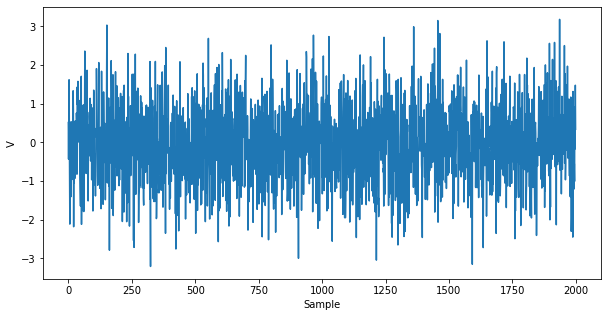

In [5]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

v = antenna.x.get_samples(2000)
    
plt.figure(figsize=(10, 5))
plt.plot(get_numpy(v))
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

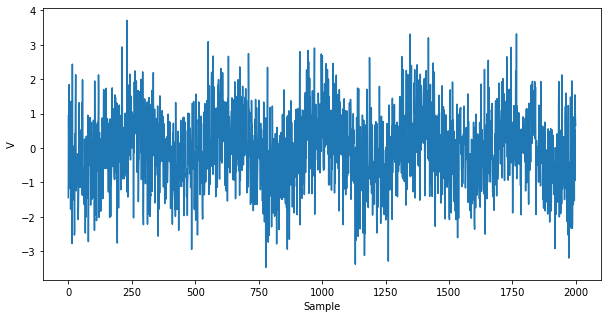

In [6]:
antenna.x.add_signal(f_start=8e6, 
                     drift_rate=-2*u.Hz/u.s, 
                     level=0.5,
                     mode='level')

v = get_numpy(antenna.x.get_samples(2000))
    
plt.figure(figsize=(10, 5))
plt.plot(get_numpy(v))
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

## Getting real voltage samples and stepping through the pipeline

First, we gather enough samples to be able to eventually do a fine channelization. Here we plot a histogram showing the overall distribution of real voltages.

(90112,)


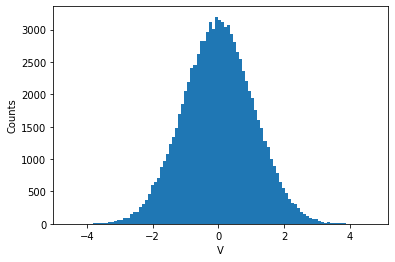

In [7]:
num_windows = 10
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

plt.hist(get_numpy(v), bins=100)
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

### Digitization

Next, we do our "digitization" step, which essentially scales the FWHM of the real voltage distribution to a desired FWHM for quantized data, which is constrained between `-2**(num_bits-1)` and `2**(num_bits-1)-1`. Plotting a histogram to show the same overall distribution:

(90112,)


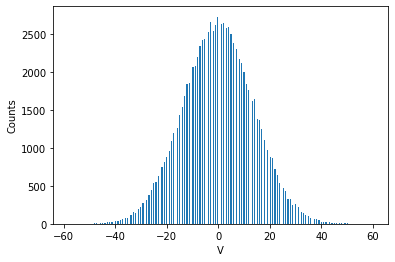

In [8]:
num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
                                      num_bits=num_bits)

v_q = digitizer.quantize(v)
print(v_q.shape)

plt.hist(get_numpy(v_q), bins=2**num_bits)
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

### Coarse channelization via Polyphase Filterbank

The quantized voltages are passed into a polyphase filterbank, and we obtain complex voltages from the real FFT. This produces `num_branches/2+1` coarse channels; in real systems, the last bin is dropped out so that we're left with `num_branches/2` effective coarse channels. Of course, you may truncate the resulting array to the desired range of coarse channels however you'd like after this step.

The shape of the data directly after channelization is `(time_samples, num_branches/2+1)`. If `num_samples=num_taps*num_branches*(num_windows+1)`, then `time_samples=num_taps*num_windows`, by design. This yields an easy formula for determing the number of real voltage samples necessary to get the desired number of time samples in our raw complex voltage data; this is built into `RawVoltageBackend` in the higher level `setigen` voltage pipeline.

Plotting histograms of real and imaginary values after the rFFT:

(80, 513)


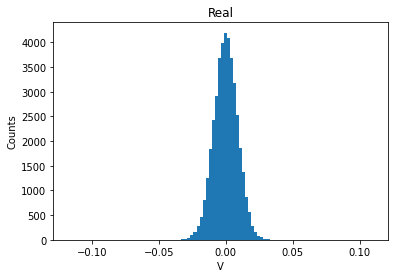

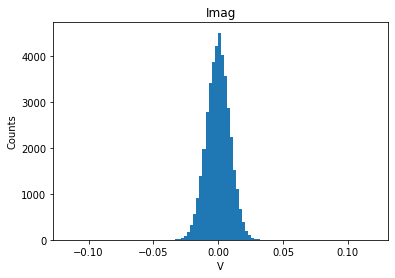

In [9]:
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

v_c = filterbank.channelize(v_q)
print(v_c.shape)

plt.hist(get_numpy(v_c.real.flatten()), bins=100)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

plt.hist(get_numpy(v_c.imag.flatten()), bins=100)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

We can also plot a spectrogram of the coarsely channelized data:

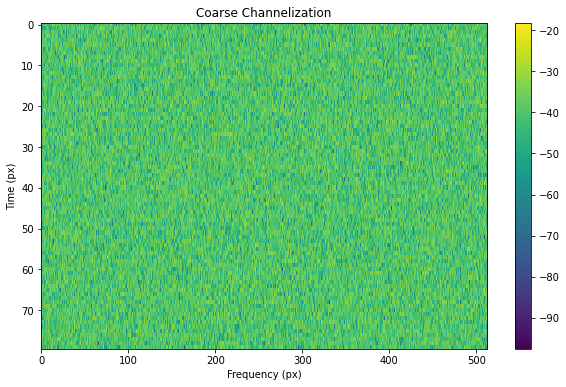

In [10]:
plt.figure(figsize=(10, 6))
plt.imshow(db(np.abs(get_numpy(v_c))**2), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Coarse Channelization")
plt.show()

### Requantization

The last data manipulation step is the requantization to either 8 or 4 bits, since these have a specific schema in GUPPI RAW format. That being said, the following cell will still work for alternate values. Plotting histograms here as well:

(80, 513)


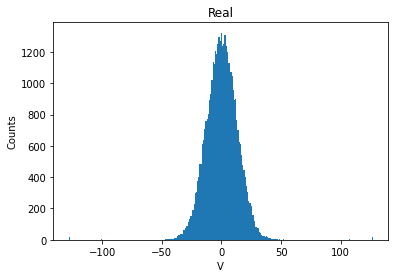

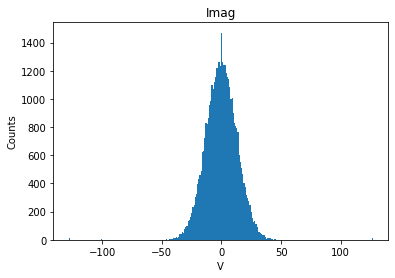

In [11]:
num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

v_rq = requantizer.quantize(v_c)
print(v_rq.shape)

plt.hist(get_numpy(v_rq.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

plt.hist(get_numpy(v_rq.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

In the standard pipeline, this is where we'd truncate to the desired range of coarse channels and save to GUPPI RAW format.

## Fine channelization
We can do a quick fine channelization to find the injected signal. Note that since we only have a few samples in the time direction, our fftlength can't be too large, but we can still clearly recover the injected signal:

Spectrogram shape: (10, 512)


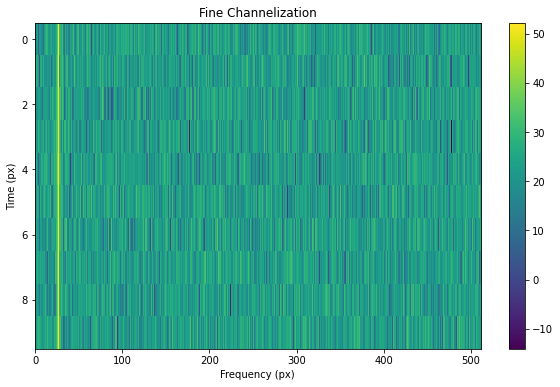

In [12]:
# Truncate coarse channels to the first 64.
v_tr = v_rq[:, 0:64]

psd = stg.voltage.get_pfb_waterfall(v_tr, int_factor=1, fftlength=8)
print(f"Spectrogram shape: {psd.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

Integrating over time:

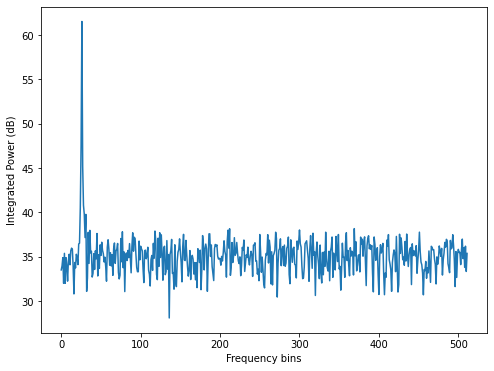

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(db(np.sum(get_numpy(psd), axis=0)))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()